# Self-Taught Learning

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* reshape
* ggplot2
* h2o

## Introduction

The 3-layer neural network and autoencoder will be implemented by library `h2o`.  

In this Jupyter notebook, there will be some comparison of the original neural network classifier and the augmented self-taught networks to be visualized.

## Import libraries

In [1]:
options(warn=-1)
library(dplyr)
library(reshape)
library(ggplot2)
library(h2o)

localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '16G', startH2O = TRUE)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'reshape'

The following object is masked from 'package:dplyr':

    rename

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 minutes 18 seconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.34.0.3 
    H2O cluster version age:    21 days, 17 hours and 23 minutes  
    H2O cluster name:           H2O_started_from_R_controlnet_kmj504 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   13.72 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



In [2]:
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

labeled.frame <- h2o.importFile(path = 'train8_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'train8_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'test8.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## Autoencoder

Use the `h2o` library to build autoencoder with one hidden layer.

In [3]:
# set neurons
neurons <- seq(20, 400, 20)

# a function to build a autoencoder based on a given neuron number
build.ae <- function(neuron) {
    h2o.deeplearning(
        x = 1:ncol(train.frame),
        training_frame = train.frame,
        hidden = c(neuron),
        epochs = 15,
        activation = "Tanh",
        autoencoder = TRUE, 
        seed = 5201, 
        rate_decay = 0.99
    )
}

# build models and calculate reconstruction errors
ae.models <- neurons %>% lapply(build.ae)
ae.errors <- ae.models %>% sapply(h2o.mse)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

The reconstruction errors of the autoencoder with the number of neurons being  from 20 to 400 with a step size of 20 are visualized below.

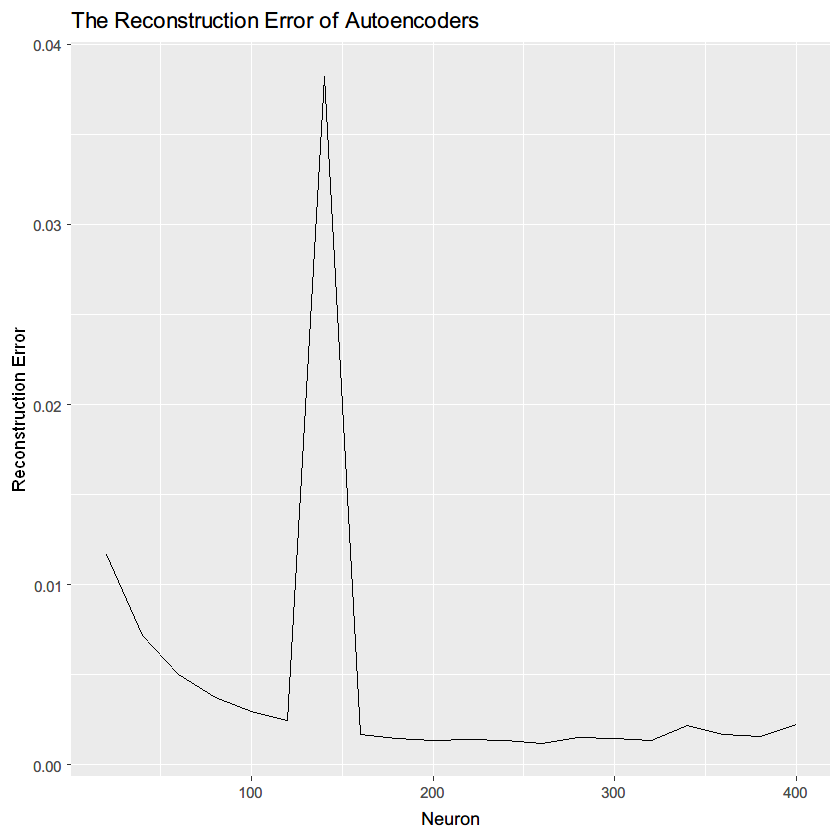

In [4]:
ggplot(data.frame(neuron = neurons, error = ae.errors)) + 
    geom_line(aes(x = neuron, y = error)) + 
    labs(x = "Neuron", y = "Reconstruction Error") + 
    ggtitle("The Reconstruction Error of Autoencoders")

Explain:

From the result, the reconstruction error decreases dramatically when the number of neurons increasing in the beginning. When the number of neurons is larger than 200, the trend of reconstruction error is stable.

In the beginning, the increasing of dimensionality of latent space can improve the capacity of representation of data, so the autoencoder can extract more useful features. With more useful features, the decoder can reconstruct the data better.

When the number of neurons is larger than 200, one single layer and the simple structure cannot extract more useful features, so the trend of reconstruction error is stable.

## Neural Network

Use `h2o` library to build 3-layer neural networks based on the number of neurons required.

In [5]:
# build nn for original features
build.nn <- function(neuron) {
    h2o.deeplearning(
        x = 2:ncol(labeled.frame),
        y = 1,
        training_frame = labeled.frame,
        hidden = c(neuron),
        epochs = 5,
        rate = 0.001,
        activation = "Tanh",
        autoencoder = FALSE, 
        seed = 42, 
        rate_decay = 0.95,
        l1 = 0.01,
        l2 = 0.1
    )
}

# record the models
nn.models <- neurons %>% lapply(build.nn)
# calculate test errors
nn.errors <- nn.models %>% sapply(function(nn) {
    1 - mean(predict(nn, test.frame)$predict == test.frame$label)
})

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

## Augmented self-taught networks

Concat the features extracted by autoencoders to dataset as extra features.

In [6]:
# concat the hidden features to original features

concat.hidden.features <- function(frame) {
    1:length(neurons) %>% lapply(function(i) {
        feature <- h2o.deepfeatures(ae.models[[i]], frame, layer=1)
        h2o.cbind(frame, feature)
    })
}

labeled.augmented.frames <- concat.hidden.features(labeled.frame)
test.augmented.frames <- concat.hidden.features(test.frame)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Train new 3-layer neural networks which has same hyperparameters as the neural networks built in previous.

In [7]:
# build augmented self-taught networks
build.augmented.nn <- function(index) {
    # choose the augmented data
    labeled.augmented.frame <- labeled.augmented.frames[[index]]
    neuron <- neurons[index]
    h2o.deeplearning(
        x = 2:ncol(labeled.augmented.frame),
        y = 1,
        training_frame = labeled.augmented.frame,
        hidden = c(neuron),
        epochs = 5,
        rate = 0.001,
        activation = "Tanh",
        autoencoder = FALSE, 
        seed = 42, 
        rate_decay = 0.95,
        l1 = 0.01,
        l2 = 0.1
    )
}

# record the models
augmented.nn.models <- 1:length(neurons) %>% lapply(build.augmented.nn)
# calculate test errors
augmented.nn.errors <- 1:length(neurons) %>% sapply(function(index) {
    nn = augmented.nn.models[[index]]
    test.augmented.frame = test.augmented.frames[[index]]
    1 - mean(predict(nn, test.augmented.frame)$predict == test.frame$label)
})

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Visualize the test errors of the models based on the original dataset and the augmented dataset.

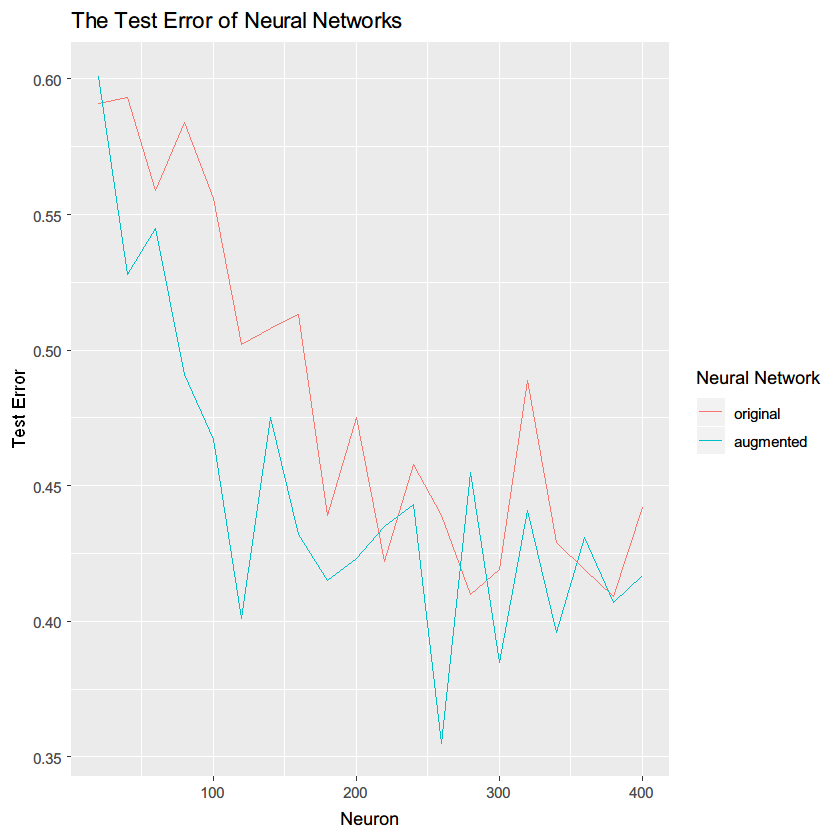

In [8]:
data.frame(neuron = neurons, original = nn.errors, augmented = augmented.nn.errors) %>% 
    melt(id.vars = "neuron") %>%
    ggplot + 
    geom_line(aes(x = neuron, y = value, color = variable)) + 
    labs(x = "Neuron", y = "Test Error", color = "Neural Network") + 
    ggtitle("The Test Error of Neural Networks")

Explain: 

From the visualization output, the test error of both original model and augmented model decreases when the number of neurons is increasing. With more hidden neurons, the neural networks can be more complex and non-linearity. Therefore, the increasing number of neurons can help model to reduce the test error.

Besides, the test error of augmented model is lower than original model in most cases. As the augmented model contains the hidden features learned in autoencoders, the neural network classifier can use the additional features to classify data, which is an improvement comparing to the original model with original features.
